# Determine the locations for six different ambulances to be placed in order to minimize the distance to any reported crashes.
## Ambulances can be assigned a new location every three hours. 

### [EDA Steps](#EDA)
1. Missing Data
2. Outliers (Check and handle)
3. Group 
4. Normalize
5. PCA
6. Encode
7. Feature selection

### Visualization

### Model
Encode year, month, day


# Variable definitions
## Train.csv:

- Uid - a unique ID
- Datetime - the date and time a crash occurred
- Latitude and Longitude - the location of the crash (not always exact due to the nature of the data collection)


## Sample Submission

- Date - a datetime column (3 hour intervals covering the test period). For example 7/1/2019 0:00 indicates the ambulance locations from 7/1/2019 0:00 to 7/1/2019 2:59.

- A\[N\]\_Latitude and A\[N\]\_Longitude - used to place ambulance N at a specific location

## Weather Info:
- The weather data comes from the GFS dataset. Descriptions of the image bands used to generate this data can be found [here](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25#description).

## Segment_info:

- segment_id - the unique ID of the specific road segment
- side - each road segment has up to two sides, i.e. traffic going in opposite directions
- The column headings are obfuscated, but we’ve maintained relationships: 79_76 and 79_65 are two related questions.

In [51]:
# !pip install geoplot



In [52]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
# import geoplot as gplt
#Show plots inline
%matplotlib inline
sns.set()

### EDA

In [265]:
# Load the data
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head(10)

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382
5,6,2018-01-01 04:04:09,-0.662939,37.208730
6,7,2018-01-01 05:31:17,-1.165228,36.960008
7,8,2018-01-01 07:57:56,-1.301303,36.820903
8,9,2018-01-01 09:57:27,-1.134640,36.848220
9,10,2018-01-01 10:48:59,-1.117207,37.008278


In [6]:
pp.ProfileReport(df)

## Summary
- No missing data
- Median Longitude is 36.844591
- Median Latitude is -1.27170948

## Visualization


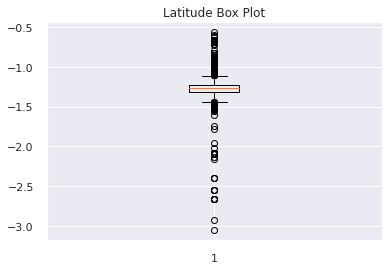

In [53]:
fig1, ax1 = plt.subplots()
ax1.set_title('Latitude Box Plot')
ax1.boxplot(df['latitude'])
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

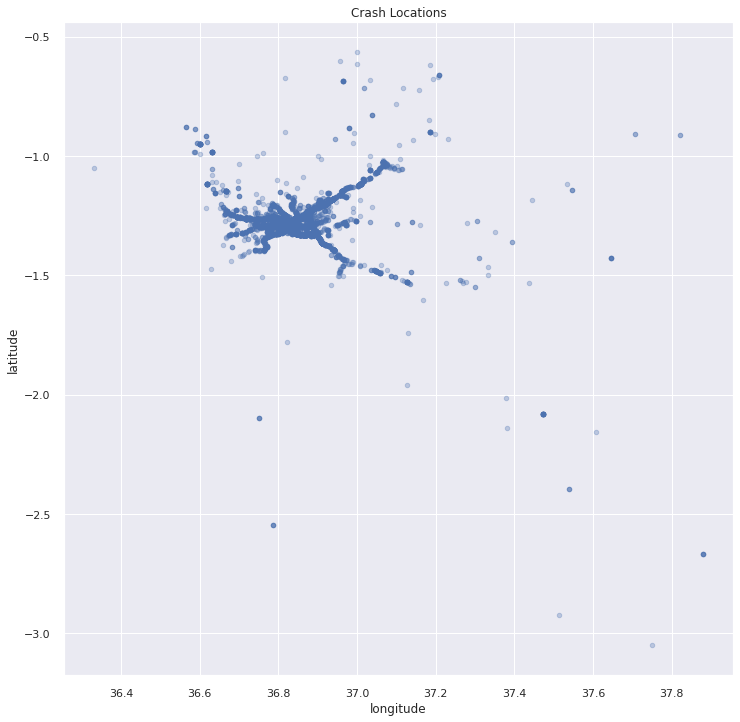

In [26]:
df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

In [54]:
df.median()

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


uid          3159.500000
latitude       -1.271709
longitude      36.844591
dtype: float64

In [230]:
df2 = df[['uid', 'latitude', 'longitude']]
Q1 = df2.quantile(0.05)
Q3 = df2.quantile(0.95)
IQR = Q3 - Q1
print(IQR)
print(df2.skew())

uid          5685.300000
latitude        0.273399
longitude       0.335203
dtype: float64
uid          0.000000
latitude    -3.239486
longitude    2.420543
dtype: float64


In [231]:
df3 = df2[~((df2 < (Q1 - 1.5 * IQR)) |(df2 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df3.shape)
print(df3.skew())

(6242, 3)
uid         -0.005392
latitude     1.076723
longitude    0.640988
dtype: float64


In [256]:
# df3.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

In [246]:
df3.shape

(6242, 3)

In [254]:
# dfz1.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

In [255]:
# pp.ProfileReport(df3)

In [495]:
from scipy import stats
import numpy as np
dfz = df[['uid', 'latitude', 'longitude']]
z = np.abs(stats.zscore(dfz))
dfz1 = dfz[(z < 3).all(axis=1)]
print(dfz1.shape)
 

(6194, 3)


In [262]:
# dfz1 = dfz[(z < 4).all(axis=1)]
# print(dfz1.skew())
# print(dfz1.shape)

In [263]:
# pp.ProfileReport(dfz1)

In [276]:
cdf = pd.merge(df3, df[['uid', 'datetime']], on='uid', how='left')
cdf.median()

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


uid          3169.500000
latitude       -1.271477
longitude      36.844089
dtype: float64

In [273]:
cdf.head()

,uid,latitude,longitude,datetime
0,1,-1.188850,36.931382,2018-01-01 00:25:46
1,4,-1.288087,36.826583,2018-01-01 03:04:01
2,5,-1.188850,36.931382,2018-01-01 03:58:49
3,7,-1.165228,36.960008,2018-01-01 05:31:17
4,8,-1.301303,36.820903,2018-01-01 07:57:56


In [37]:
# def calc_dist(df, cols):
#     lat, = cols[0], cols[1]

#     dist = ((lat - median_lat)**2 + (lon - median_lon)**2)**0.5 
#     return dist

In [291]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth


In [329]:
X = cdf.loc[:, ['latitude', 'longitude']]

In [298]:
# import matplotlib.pyplot as plt
# from itertools import cycle

# plt.figure(1)
# # plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

In [407]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans,SpectralClustering

In [306]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
            for i in range(n_clusters)])
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels



In [627]:
tdf = df.sample(5000)


In [898]:
def round_hr(t):
    timestamp = t + pd.DateOffset(minutes=90)
    hr = (timestamp.hour + (timestamp.minute/60) - 1.5) / 3
    return round(hr) * 3

print(round_hr(pd.Timestamp('2019-03-13 01:29:37')))

0


In [673]:
bytime = tdf.groupby(['timegroup']).median().reset_index()[['timegroup','latitude','longitude']]
bytime

,timegroup,latitude,longitude
0,0,-1.260720,36.855262
1,3,-1.287571,36.848056
2,6,-1.269239,36.843123
3,9,-1.271580,36.837474
4,12,-1.281001,36.845429
5,15,-1.284440,36.855547
6,18,-1.260714,36.851785
7,21,-1.268828,36.851239


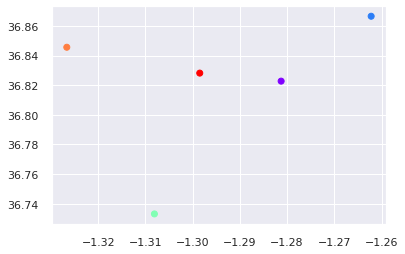

In [612]:
plt.scatter(tdf.loc[:,['latitude']],tdf.loc[:,['longitude']], label='True Position', c=[tdf['bin']], cmap='rainbow')

In [442]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1)
#         print(row)
        # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = (
                (c_lat - row[f'A{a}_Latitude'].values[0])**2 + (c_lon - row[f'A{a}_Longitude'].values[0])**2
            )**0.5 
            dists.append(dist)
#         print(min(dists))
        total_distance += min(dists)
    return total_distance


In [684]:
X = cdf.loc[:, ['latitude', 'longitude']]
kmeans = MiniBatchKMeans(n_clusters=6)
kmeans.fit(X)
# kmeans.transform(X)
# print(kmeans.subcluster_centers_)
print(kmeans.labels_)
print(kmeans.cluster_centers_.tolist())

[4 2 4 ... 0 2 4]
[[-1.3240368811398529, 36.87398717065023], [-1.0896365333482414, 37.023793584143526], [-1.2820729435554266, 36.77808911272622], [-1.469689031870404, 37.02577657533693], [-1.229460374527058, 36.88424463247906], [-1.0419048010165544, 36.63449082971357]]


In [697]:
cdf = parse_dates(df)
df0 = cdf[cdf['timegroup'] == 0]
# df0.describe()

In [791]:
curdf = df[df['hour'] == hour]
res = find_kmeans(curdf)
print(res)

[[-1.2123027950574359, 36.90634995405141], [-2.26993277069289, 37.385892286852695], [-1.3043064518043606, 36.842117039266284], [-1.4657745544423462, 37.074945709252624], [-1.2349148315264549, 36.72512159275547], [-1.021416275777975, 37.061627610530685]]


106.8461493464151

In [ ]:
# Example:
def round_hr(timestamp):
#     timestamp = t + pd.DateOffset(minutes=90)
    hr = (timestamp.hour + (timestamp.minute/60) - 1.5) / 3
    return round(hr) * 3


def parse_dates(tdf):
    days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4:'Friday', 5: 'Saturday', 6:'Sunday'}
    tdf['weekday'] = tdf['datetime'].transform(lambda d: d.dayofweek)
    tdf['hour'] = tdf['datetime'].transform(lambda d: d.hour)
    tdf['minute'] = tdf['datetime'].transform(lambda d: d.minute)
    tdf['timegroup'] = tdf['datetime'].apply(lambda d: round_hr(d))
    return tdf


def remove_outliers(df):
    df2 = df[['uid', 'latitude', 'longitude']]

#     Q1 = df2.quantile(0.10)
#     Q3 = df2.quantile(0.90)
#     IQR = Q3 - Q1
#     df3 = df2[~((df2 < (Q1 - 1.5 * IQR)) |(df2 > (Q3 + 1.5 * IQR))).any(axis=1)]

    z = np.abs(stats.zscore(df2))
    df3 = dfz[(z < 3).all(axis=1)]

    cdf = pd.merge(df3, df[['uid', 'datetime']], on='uid', how='left')
    return df

# Test set
def sub_df():
    reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

    # Date range covering test set
    dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

    # Create submission dataframe
    sub = pd.DataFrame({
        'date':dates
    })

    for ambulance in range(6):
        sub['A'+str(ambulance)+'_Latitude'] = 0.0
        sub['A'+str(ambulance)+'_Longitude'] = 0.0

    sub['hour'] = sub['date'].transform(lambda d: d.hour)
    sub['weekday'] = sub['date'].transform(lambda d: d.dayofweek)

    return sub


def find_kmeans(cdf):
    X = cdf.loc[:, ['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=6, max_iter=1000)
    kmeans.fit(X)
    # kmeans.transform(X)
    # print(kmeans.subcluster_centers_)
    # print(kmeans.labels_)
    # print(kmeans.cluster_centers_.tolist())


    klist = kmeans.cluster_centers_.tolist()
    return klist
# hrs
def train(df):
    sdf = sub_df()
    hour_list = sdf['hour'].unique()
    for hour in hour_list:
        curdf = df[df['hour'] == hour]
#         rdf = remove_outliers(curdf)
        clist = find_kmeans(curdf)
        for i in sdf[sdf['hour'] == hour].index:  
            for ambulance in range(6):
                sdf.at[i, 'A'+str(ambulance)+'_Latitude'] = clist[ambulance][0]
                sdf.at[i, 'A'+str(ambulance)+'_Longitude'] = clist[ambulance][1]
    return sdf

# # days - better
# def train(df):
#     sdf = sub_df()
#     daylist = sdf['weekday'].unique()
#     for day in daylist:
#         curdf = df[df['weekday'] == day]
# #         rdf = remove_outliers(curdf)
#         clist = find_kmeans(curdf)
#         for i in sdf[sdf['weekday'] == day].index:  
#             for ambulance in range(6):
#                 sdf.at[i, 'A'+str(ambulance)+'_Latitude'] = clist[ambulance][0]
#                 sdf.at[i, 'A'+str(ambulance)+'_Longitude'] = clist[ambulance][1]
#     return sdf

# # whole
# def train(df):
#     sdf = sub_df()
# #   rdf = remove_outliers(curdf)
#     clist = find_kmeans(curdf)
#     for i in range(6):  
#         for ambulance in range(6):
#             sdf['A'+str(ambulance)+'_Latitude'] = clist[ambulance][0]
#             sdf['A'+str(ambulance)+'_Longitude'] = clist[ambulance][1]
         
#     return sdf


df = pd.read_csv('Train.csv', parse_dates=['datetime'])
# rdf = remove_outliers(df)
pdf = parse_dates(df)
sub = train(pdf).iloc[:,:-2]

# list = [[-1.3002698101567285, 36.849180258448285], [-1.2132308502371028, 36.904674270813274], [-1.2787178876244554, 36.75147390243593], [-1.4482536451543153, 37.02618538575785], [-1.0605665264409756, 37.040648693082595], [-1.0477381718934722, 36.6295973904912]]
# list =[[-1.3033739473331676, 36.844120311235855], [-1.0612871721400112, 37.044174850193535], [-0.9903432099267782, 36.62477920905066], [-1.4459781581697861, 37.015763739438064], [-1.264834668114922, 36.74460500868688], [-1.2145366242735378, 36.90176780277249]]

# for ambulance in range(6):
#     sub['A'+str(ambulance)+'_Latitude'] = list[ambulance][0]
#     sub['A'+str(ambulance)+'_Longitude'] = list[ambulance][1]
    
score(sub, reference)    #100.50064704840804

# sub

In [1106]:
pdf = parse_dates(df)
pdf.groupby('weekday').count()
pdf
def train(df):
    sdf = sub_df()
    daylist = sdf['weekday'].unique()
    for day in daylist:
        curdf = df[df['weekday'] == day]
#         rdf = remove_outliers(curdf)
        clist = find_kmeans(curdf)
        for i in sdf[sdf['weekday'] == day].index:  
            for ambulance in range(6):
                sdf.at[i, 'A'+str(ambulance)+'_Latitude'] = clist[ambulance][0]
                sdf.at[i, 'A'+str(ambulance)+'_Longitude'] = clist[ambulance][1]
    tsdf = sdf.iloc[:,:-2]          
    return tsdf
sub = train(pdf)
sub
# score(sub, reference) 


,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
1,2019-01-01 03:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
2,2019-01-01 06:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
3,2019-01-01 09:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
4,2019-01-01 12:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2019-12-31 12:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
2917,2019-12-31 15:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
2918,2019-12-31 18:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461
2919,2019-12-31 21:00:00,-1.217228,36.909884,-2.248824,37.108602,-1.223705,36.708700,-0.990656,37.036318,-2.66757,37.879490,-1.306131,36.848461


In [1059]:
sub.to_csv('test.csv', index=False)
tt = pd.read_csv('test.csv')
tt.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude,hour
0,2019-01-01 00:00:00,-1.212287,36.910917,-2.398108,36.77491,-1.224357,36.709495,-2.454559,37.715541,-1.306494,36.849521,-0.962427,37.042421,0
1,2019-01-01 03:00:00,-1.212287,36.910917,-2.398108,36.77491,-1.224357,36.709495,-2.454559,37.715541,-1.306494,36.849521,-0.962427,37.042421,3
2,2019-01-01 06:00:00,-1.212287,36.910917,-2.398108,36.77491,-1.224357,36.709495,-2.454559,37.715541,-1.306494,36.849521,-0.962427,37.042421,6
3,2019-01-01 09:00:00,-1.212287,36.910917,-2.398108,36.77491,-1.224357,36.709495,-2.454559,37.715541,-1.306494,36.849521,-0.962427,37.042421,9
4,2019-01-01 12:00:00,-1.212287,36.910917,-2.398108,36.77491,-1.224357,36.709495,-2.454559,37.715541,-1.306494,36.849521,-0.962427,37.042421,12


In [439]:
X = cdf.loc[:, ['latitude', 'longitude']]
kmeans = SpectralClustering(n_clusters=6)
res = kmeans.fit_predict(X)
# print(kmeans.cluster_centers_)
# print(kmeans.labels_)
# print(kmeans.cluster_centers_.tolist())


{'affinity': 'rbf', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 6, 'n_components': None, 'n_init': 10, 'n_jobs': None, 'n_neighbors': 10, 'random_state': None}


In [427]:
dx = X.groupby(kmeans.labels_)
dx.head()

,latitude,longitude
0,-1.188850,36.931382
1,-1.288087,36.826583
2,-1.188850,36.931382
3,-1.165228,36.960008
4,-1.301303,36.820903
9,-1.605062,37.166918
10,-1.310657,36.805481
12,-1.264331,36.746984
13,-1.264267,36.746985
15,-1.264331,36.746984


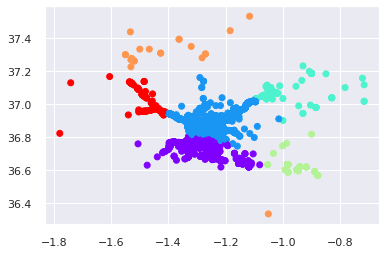

In [436]:
plt.scatter(X.iloc[:,0],X.iloc[:,1], c=kmeans.labels_, cmap='rainbow')